## Fine tuning DeiT-base on MNIST

### Import dependencies

In [12]:
import torch
import torchvision
from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from deit_helper import deit_base

### Define transforms
Extend color channels from grayscale (2 channels) to RGB (3 channels), resize to 256x256, normalize to ImageNet mean and stdev. Partially taken from: https://pytorch.org/tutorials/beginner/vt_tutorial.html

In [26]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(224, interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

/home/max/anaconda3/envs/torch_svhn/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


## Get MNIST dataset and build dataloaders

In [27]:
dataset_train = torchvision.datasets.MNIST(root = 'data/', train = True, transform = transform, download = True)
dataset_test = torchvision.datasets.MNIST(root = 'data/', train = False, transform = transform, download = True)

In [28]:
batch_size = 12

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last=True)

### Visualize some training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


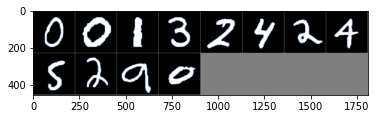

    0     0     1     3     2     4     2     4     5     2     9     0


In [29]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Build DeiT-base model
Calling 'deit_base' from deit_helper returns a model with the desired number of output classes and frozen parameters for all layers except the last one.

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = deit_base(10).to(device)

Using cache found in /home/max/.cache/torch/hub/facebookresearch_deit_main


## Train model

### Build optimizer, loss function, and learning rate scheduler

In [31]:
trainable_params = [param for param in model.parameters() if param.requires_grad]

In [32]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(trainable_params, lr = 0.001, momentum = 0.9)
lrs = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001, steps_per_epoch=len(trainloader), epochs = 3)

In [33]:
model.train()
for epoch in range(3):
    running_loss = 0.0
    last_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lrs.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f lr: %.10f' % (epoch + 1, i + 1, running_loss/200, optimizer.param_groups[0]['lr']))
            last_loss = running_loss/200
            running_loss = 0.0

print('Finished training.')

[1,   200] loss: 2.084 lr: 0.0000446734
[1,   400] loss: 1.612 lr: 0.0000586026
[1,   600] loss: 1.250 lr: 0.0000815164
[1,   800] loss: 1.010 lr: 0.0001129685
[1,  1000] loss: 0.839 lr: 0.0001523465
[1,  1200] loss: 0.684 lr: 0.0001988837
[1,  1400] loss: 0.571 lr: 0.0002516739
[1,  1600] loss: 0.530 lr: 0.0003096890
[1,  1800] loss: 0.469 lr: 0.0003717994
[1,  2000] loss: 0.401 lr: 0.0004367956
[1,  2200] loss: 0.411 lr: 0.0005034120
[1,  2400] loss: 0.338 lr: 0.0005703514
[1,  2600] loss: 0.341 lr: 0.0006363104
[1,  2800] loss: 0.316 lr: 0.0007000045
[1,  3000] loss: 0.296 lr: 0.0007601935
[1,  3200] loss: 0.297 lr: 0.0008157053
[1,  3400] loss: 0.272 lr: 0.0008654590
[1,  3600] loss: 0.261 lr: 0.0009084857
[1,  3800] loss: 0.254 lr: 0.0009439476
[1,  4000] loss: 0.236 lr: 0.0009711543
[1,  4200] loss: 0.241 lr: 0.0009895758
[1,  4400] loss: 0.226 lr: 0.0009988535
[1,  4600] loss: 0.230 lr: 0.0009997717
[1,  4800] loss: 0.218 lr: 0.0009979737
[1,  5000] loss: 0.213 lr: 0.0009943931


In [34]:
PATH = 'deit_base_mnist_11022021_1.pth'
torch.save(model.state_dict(), PATH)

## Visualize test images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


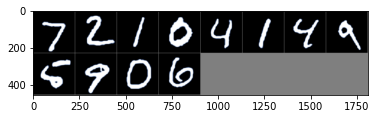

Ground Truth:      7     2     1     0     4     1     4     9     5     9     0     6


In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(12)))

## Make predictions on above images

In [36]:
model = deit_base(10)
model.load_state_dict(torch.load(PATH))
model.eval()

Using cache found in /home/max/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [37]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(12)))

Predicted:      7     2     1     0     4     1     4     9     5     9     0     6


## Test network on entire test dataset

In [43]:

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on test images is: %d %%' % (100 * correct/total))

Accuracy of the network on test images is: 96 %
